_Work in progress_

In this post I clean up some data on daily birth numbers in the Netherlands and Belgium. When our daughter was born, it was very busy, lots of babies were born. This was told to us independently by doctors, nurses and other professionals in babies. So I started thinking about the variance in the number of babies that are born in a time period. It would be nice to have the number of babies born each day (each hour!) in Amsterdam, but I could only find data from the Netherlands, and also daily data from Belgium, which I include as well for later reference. 

The original data can be found through the links below. In this post I clean up the data and I include some initial exploration. The clean files, and this notebook, can be found on my GitHub. 

* http://statline.cbs.nl/Statweb/publication/?DM=SLNL&PA=70703ned&D1=0&D2=a&HDR=T&STB=G1&VW=D
* http://statbel.fgov.be/nl/statistieken/opendata/datasets/bevolking/

The goal is to later do some research on the technical topics of Gaussian Processes and overdispersion. The research questions I have in mind for now are

* How much clustering is there in the number of babies that are born? How much of that can we explain with seasonal patterns? 
* Is there evidence that an expanding economy or job market has something to do with the number of babies born?
* What are the slow-moving and fast-moving trends in this data?

In [161]:
## usual prerequisites

import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/gijs/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [162]:
## data is downloaded locally but can found through the links provided

daily_ned = pd.read_csv("./data/Bevolkingsontwikkeli_171217121849.csv", 
                        encoding="latin-1", 
                        delimiter=";", 
                        skiprows=[1, 2, 3, 4]).reset_index()

daily_ned.columns = ["datum", "births"]
daily_ned.geboortes = pd.to_numeric(daily_ned.births, errors = "coerce")
daily_ned.head(7)

,datum,births
0,Totaal januari 1995,16436.0
1,Zondag 1 januari 1995,368.0
2,Maandag 2 januari 1995,439.0
3,Dinsdag 3 januari 1995,529.0
4,Woensdag 4 januari 1995,569.0
5,Donderdag 5 januari 1995,565.0
6,Vrijdag 6 januari 1995,573.0


In [163]:
## removing the total columns and converting the numbers to ints

daily_ned = daily_ned[~daily_ned.datum.str.lower().str.contains("totaal")].dropna()
daily_ned.births = daily_ned.births.astype(int)

daily_ned.sample(10)

,datum,births
585,Vrijdag 12 juli 1996,589
4510,Donderdag 21 september 2006,570
7210,2013 dinsdag 1 oktober,573
3065,Maandag 23 december 2002,591
6821,2012 donderdag 20 september,559
5258,Zaterdag 30 augustus 2008,453
5803,Zaterdag 23-1-2010,461
2805,Maandag 15 april 2002,515
6021,Zondag 22-8-2010,422
5828,Dinsdag 16-2-2010,534


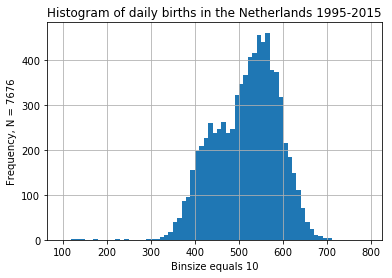

In [164]:
daily_ned.births.plot.hist(bins = np.arange(100, 800, 10), 
                           title = "Histogram of daily births in the Netherlands 1995-2015");

plt.grid(True)
plt.ylabel(f"Frequency, N = {len(daily_ned)}")
plt.xlabel("Binsize equals 10");

The distribution of dates looks insteresting with two bumps and some weird outliers. Looks like I retrieved the original data anyway. 

### Parsing the dates

Not only is the date format very nonstandard, there are three different formats used. This is from CBS, the official supplier of statistics in the Netherlands. If I was completely certain the dates are in order, and nothing is missing, just generating a new daterange is much quicker, but I chose to just deal with it and parse all the dates. 

In [165]:
## first format

fmt_yd = daily_ned.datum.str.extract("(?P<year>\d{4}) [a-z]{6,10} (?P<day>\d{1,2}) (?P<month_named>[a-z]{3,11})", expand = True).dropna()
fmt_yd[fmt_yd.any(axis = 1)].sample(5)

,year,day,month_named
7245,2013,5,november
6601,2012,20,februari
6869,2012,5,november
7271,2013,1,december
7190,2013,11,september


To translate the named months to numbers (), I couldn't find a list of the dutch months in this particular format, so I'll write them myself. Since the names are in Dutch, if I could somehow set the locale of the date formatting, it would be nice to use a formatting string, but I didn't find that option. Writing regexes, especially named ones, feels good anyway! 

In [166]:
months = ["januari", "februari", "maart", "april", "mei", "juni", "juli", "augustus", "september", "oktober", "november", "december"]
fmt_yd["month"] = fmt_yd.dropna().month_named.astype('category').cat.reorder_categories(months).cat.codes + 1
fmt_yd.sample(5)

,year,day,month_named,month
6727,2012,21,juni,6
6797,2012,28,augustus,8
7951,2015,31,augustus,8
6241,2011,15,maart,3
7244,2013,4,november,11


In an undocumented feature that I found through [GitHub](https://github.com/nps/pandas/commit/cb7cdaa20ef5af421344819232ee289b93e22e7f), it is possible to combine columns of parts of dates into a datetime64-series. The alternative would be to use `.map` or `.apply`, but that would be much slower. There is no easy way to create an array of datetimes in `numpy`, which seems a bit weird, but it was alluded to, I believe in the recent [announcement](https://www.moore.org/grant-detail?grantId=GBMF5447) of the first ever (...) `numpy` funding round by the Moore foundation, to be spent by the Berkeley Institute for Data Science.  

In [167]:
yd_dates = pd.to_datetime(fmt_yd.drop('month_named', axis = 1))
yd_dates.sample(5)

7602   2014-10-07
6715   2012-06-09
7814   2015-04-16
7763   2015-02-24
7213   2013-10-04
dtype: datetime64[ns]

The same system can be used to extract the other format. 

In [168]:
fmt_m = daily_ned.datum.str.extract("(?P<day>\d{1,2}) (?P<month_named>[a-z]{3,11}) ?(?P<year>\d{4})", expand = True).dropna()
fmt_m["month"] = fmt_m.month_named.astype('category').cat.reorder_categories(months).cat.codes + 1
m_dates = pd.to_datetime(fmt_m.drop('month_named', axis = 1))

m_dates.sample(5)

1184   1998-01-28
1140   1997-12-24
5249   2008-08-21
2077   2000-05-26
3240   2003-06-02
dtype: datetime64[ns]

There is also a numerical format which can be parsed easily with a formatting string. 

In [169]:
num_dates = pd.to_datetime(daily_ned.datum, format = "%d-%m-%Y", exact = False, errors = "coerce").dropna()
num_dates.sample(5)

5742   2009-12-03
5711   2009-11-03
5840   2010-02-28
5545   2009-05-27
6078   2010-10-16
Name: datum, dtype: datetime64[ns]

In [170]:
daily_ned = daily_ned.assign(date = pd.concat([yd_dates, m_dates, num_dates]))
daily_ned.sample(5)

,datum,births,date
7184,2013 donderdag 5 september,492,2013-09-05
1713,Woensdag 16 juni 1999,619,1999-06-16
2798,Maandag 8 april 2002,543,2002-04-08
7800,2015 donderdag 2 april,479,2015-04-02
1415,Dinsdag 8 september 1998,629,1998-09-08


In [171]:
## There are a couple of `Other` columns

daily_ned[daily_ned.date.isnull()]

,datum,births,date
5779,Overig,243,NaT
6549,Overig,171,NaT
6936,Overig,131,NaT
7310,Overig,144,NaT
7696,Overig,229,NaT
8082,Overig,121,NaT


In [172]:
## remove the unused columns and 'other' rows
## the data is now in the format I want it to be! 

daily_ned = daily_ned.dropna().drop('datum', axis = 1, errors = 'ignore').reset_index(drop = True)
daily_ned.to_feather("./data/clean/daily_ned_births.feather")
daily_ned.sample(5)

,births,date
2108,547,2000-10-09
6032,558,2011-07-08
289,547,1995-10-17
7144,558,2014-07-24
4410,390,2007-01-28


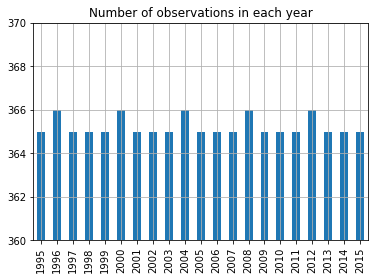

In [173]:
daily_ned.dropna().date.dt.year.value_counts().sort_index().plot.bar()
plt.ylim((360, 370))
plt.title("Number of observations in each year")
plt.grid();

A yes, the extra February 29th each year.

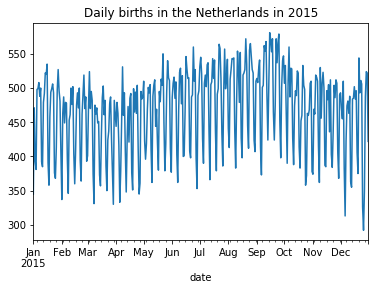

In [174]:
daily_ned[daily_ned.date.dt.year == 2015].set_index('date').births.plot(
    title = "Daily births in the Netherlands in 2015"
);

## Data from Belgium

The data from Belgium is a bit more recent, but for a shorter period (2008-2016) than the Dutch data (1995-2015). The format is a lot better, without any cruft in there, and normal dateformatting. As a result, the cleaning up is only a couple of steps.  

In [175]:
daily_bel = pd.read_csv("./data/TF_BIRTHS.txt", sep = "|")
daily_bel.columns = "date", "births"
daily_bel.date = pd.to_datetime(daily_bel.date)
daily_bel.sample(5)

,date,births
2219,2014-01-28,408
2804,2015-09-05,231
2634,2015-03-19,357
563,2009-07-17,409
700,2009-12-01,388


In [176]:
## every year has the correct number of days?

daily_bel.date.dt.year.value_counts().sort_index()

2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
Name: date, dtype: int64

In [177]:
## no duplicated dates ?

daily_bel.date.duplicated().sum()

0

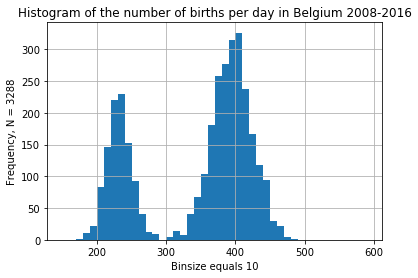

In [178]:
daily_bel.births.plot.hist(
    bins = np.arange(150, 600, 10), 
    title = "Histogram of the number of births per day in Belgium 2008-2016"
);

plt.grid()
plt.xlabel("Binsize equals 10")
plt.ylabel(f"Frequency, N = {len(daily_bel)}");

Some overdispersion is to be expected, but this last graph is a bit weird. Perhaps for some years, only the north or the south of Belgium is included in the statistics? Or is it a big weekend effect?

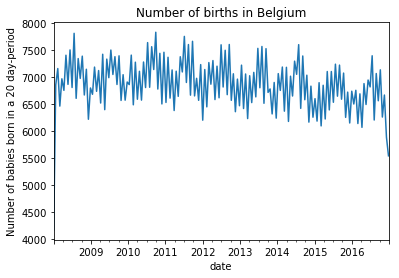

In [181]:
daily_bel.groupby(daily_bel.date.dt.round('20d')).sum().births.plot(
    title = "Number of births in Belgium"
)

plt.ylabel("Number of babies born in a 20 day-period");

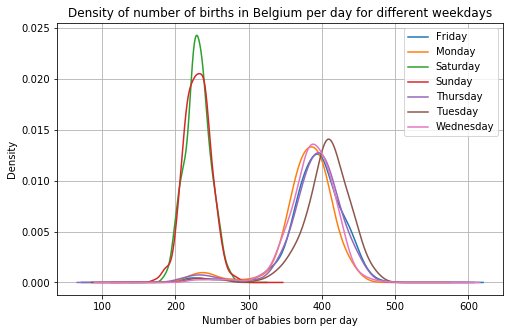

In [207]:
daily_bel.groupby(
    daily_bel.date.dt.weekday_name
).births.plot.density(
    legend = True,
    grid = True, 
    figsize = (8, 5),
    title = "Density of number of births in Belgium per day for different weekdays"
)

plt.xlabel("Number of babies born per day");

Alright, that's the weekend effect then. This effect seems to be a lot bigger than in the Netherlands. In the last graph, a density works a bit better than a histogram for comparing the days.

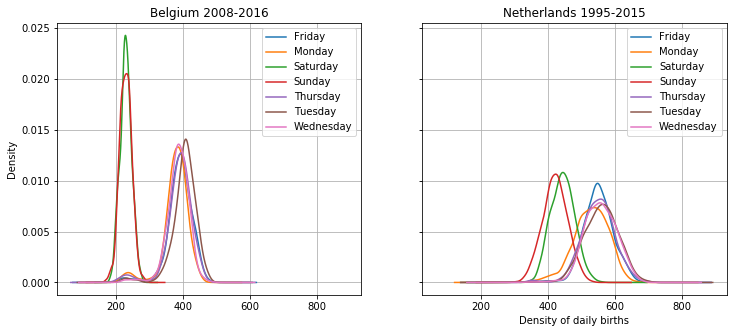

In [216]:
_, axes = plt.subplots(nrows=1, sharex = True, sharey = True, ncols=2, figsize = (12, 5))

daily_bel.groupby(
    daily_bel.date.dt.weekday_name
).births.plot.density(
    legend = True,
    grid = True, 
    ax = axes[0]
)

daily_ned.groupby(
    daily_ned.date.dt.weekday_name
).births.plot.density(
    legend = True,
    grid = True, 
    ax = axes[1]
)

axes[0].set_title("Belgium 2008-2016")
axes[1].set_title("Netherlands 1995-2015")

plt.xlabel("Density of daily births");

Densities are always hard to interpret though, especially the height difference here. The point of this graph is to show that there is a large difference between the weekends and the weekdays, and that that effect is stronger in Belgium than in the Netherlands. But you always get more with a graph! The height difference is apparent, which means that there is less variance in the births in Belgium, especially on weekends. This is at least in part because there are less births in belgium anyway, so the variance is less as well. 

In addition, there is a difference between sundays and saturdays in the Netherlands. Also some interesting bumps in the lower numbers for weekdays for both countries, perhaps these have to do with festivities? Tuesdays are popular in Belgium, mondays are less popular in the Netherlands. Interesting! I will continue the analysis of these differences in another post. 

As mentioned, I want to explore the idea of overdispersion and Gaussian Process regression. Perhaps time series forecasting is also interesting here, especially the evaluation. I just save the data for now. You can find it on GitHub. 

In [140]:
daily_bel.to_feather("./data/clean/daily_bel_births.feather")